<a href="https://colab.research.google.com/github/20007213/coding3-weekly-homework/blob/main/coding3_week4.2_quiz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

   
import  os
import  tensorflow as tf
import  numpy as np
from    tensorflow import keras
from    tensorflow.keras import Sequential, layers
from    PIL import Image
from    matplotlib import pyplot as plt

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils.vis_utils import plot_model
from keras import backend as K

from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from keras.layers import Reshape, Flatten, BatchNormalization, Activation

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os


# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [4]:
tf.random.set_seed(22)
np.random.seed(22)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
assert tf.__version__.startswith('2.')


def save_images(imgs, name):
    new_im = Image.new('L', (280, 280))

    index = 0
    for i in range(0, 280, 28):
        for j in range(0, 280, 28):
            im = imgs[index]
            im = Image.fromarray(im, mode='L')
            new_im.paste(im, (i, j))
            index += 1

    new_im.save(name)

In [5]:
h_dim = 20
batchsz = 512
lr = 1e-3

In [36]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train, x_test = x_train.astype(np.float32) / 255., x_test.astype(np.float32) / 255.

input_shape = x_train[0].shape
x_train = np.reshape(x_train, x_train.shape+(1,))
x_test = np.reshape(x_test, x_test.shape+(1,))


print("input_shape:", input_shape)
print("x_train:", x_train.shape)
print("x_test:", x_test.shape)

input_shape: (28, 28)
x_train: (60000, 28, 28, 1)
x_test: (10000, 28, 28, 1)


(28, 28, 1) stats: 1.0 0.0 0.29280713


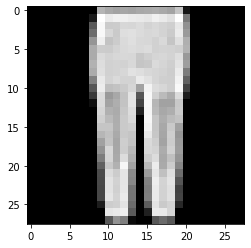

In [7]:
# Let's look at one sample:
x1 = x_test[3000] 
print(x1.shape, "stats:", np.max(x1), np.min(x1), np.mean(x1))

#Show it as an image:
plt.figure(figsize=(4,4))
plt.imshow(x1[:,:,0], cmap='gray', vmin=0.0, vmax=1.0)
plt.show()

In [ ]:
import numpy as np

train_data = np.load('QuickDraw10/dataset/train-ubyte.npz')
test_data  = np.load('QuickDraw10/dataset/test-ubyte.npz')

x_train, y_train = train_data['a'], test_data['b']
x_test,  y_test  = test_data['a'],  test_data['b']

In [37]:
x_train = x_train.astype('float32')
x_test =  x_test.astype('float32')
print (x_train.shape)
print (x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [38]:
np.max(x_train)

1.0

In [69]:
input_shape = (28, 28, 1)
latent_dim = 128
# VAE model = encoder + decoder

# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')

# 2 4 8 16 32 64 128 256 512 1024

kernels = 128

x = Conv2D(kernels, (3), activation='tanh', padding='same')(inputs)
x = MaxPooling2D((2), padding='same')(x)
x = BatchNormalization()(x)

x = Conv2D(int(kernels/2), (3), activation='tanh', padding='same')(x)
x = MaxPooling2D((2), padding='same')(x)
x = BatchNormalization()(x)

x = Conv2D(int(kernels/4), (3), activation='tanh', padding='same')(x)
x = MaxPooling2D((2), padding='same')(x)
x = BatchNormalization()(x)

intermediate_conv_shape = x.get_shape()
x = Flatten()(x)


x = BatchNormalization()(x)
x = Activation("tanh")(x)

_,n,m,o = intermediate_conv_shape # (None, 4, 4, 6) # 96
intermediate_dim = n*m*o

#some fully connected layers in the middle?
#x = Dense(intermediate_dim, activation='tanh')(x)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='tanh')(latent_inputs)

# optionally BN?
x = BatchNormalization()(x)
x = Activation("tanh")(x)

x = Reshape((n,m,o))(x)
x = Conv2D(int(kernels/4), (3), activation='tanh', padding='same')(x)
x = UpSampling2D((2))(x)
x = BatchNormalization()(x)
x = Conv2D(int(kernels/2), (3), activation='tanh', padding='same')(x)
x = UpSampling2D((2))(x)
x = BatchNormalization()(x)
x = Conv2D(int(kernels), (3), activation='tanh')(x)
x = UpSampling2D((2))(x)
x = BatchNormalization()(x)

outputs = Conv2D(1, (3), activation='sigmoid', padding='same')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [62]:
encoder.summary()
#plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)
decoder.summary()
#plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_28 (Conv2D)             (None, 28, 28, 40)   400         ['encoder_input[0][0]']          
                                                                                                  
 max_pooling2d_12 (MaxPooling2D  (None, 14, 14, 40)  0           ['conv2d_28[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_29 (Conv2D)             (None, 14, 14, 20)   7220        ['max_pooling2d_12[0][0]'] 

In [70]:
models = (encoder, decoder)
data = (x_test, y_test)

args_mse = False
# VAE loss = mse_loss or xent_loss + kl_loss
if args_mse:
    reconstruction_loss = mse(inputs, outputs)
else:
    reconstruction_loss = binary_crossentropy(inputs, outputs)

m = input_shape[0]*input_shape[1]
reconstruction_loss *= m # 28x28 values
reconstruction_loss = K.sum(reconstruction_loss)
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae_loss /= m
vae_loss /= m
vae.add_loss(vae_loss)
vae.compile(optimizer='Adam')
vae.summary()

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 encoder (Functional)           [(None, 128),        227808      ['encoder_input[0][0]']          
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                                  
 decoder (Functional)           (None, 28, 28, 1)    171745      ['encoder[0][2]']                
                                                                                            

In [71]:
batch_size = 128
epochs = 10

#history = vae.fit(x_train[0:1000], epochs=epochs, shuffle=True, batch_size=batch_size, validation_data=(x_test, None))
history = vae.fit(x_train, epochs=epochs, shuffle=True, batch_size=batch_size, validation_data=(x_test, None))

Epoch 1/10
469/469 [==============================] - 61s 124ms/step - loss: 43.5403 - val_loss: 42.3813
Epoch 2/10
469/469 [==============================] - 56s 120ms/step - loss: 37.3031 - val_loss: 47.6857
Epoch 3/10
469/469 [==============================] - 57s 122ms/step - loss: 36.3244 - val_loss: 48.8989
Epoch 4/10
469/469 [==============================] - 58s 124ms/step - loss: 35.7793 - val_loss: 42.9096
Epoch 5/10
469/469 [==============================] - 58s 124ms/step - loss: 35.5137 - val_loss: 37.9803
Epoch 6/10
469/469 [==============================] - 58s 124ms/step - loss: 35.2529 - val_loss: 38.8422
Epoch 7/10
469/469 [==============================] - 55s 118ms/step - loss: 34.9579 - val_loss: 39.1499
Epoch 8/10
469/469 [==============================] - 61s 130ms/step - loss: 34.8237 - val_loss: 38.6119
Epoch 9/10
469/469 [==============================] - 59s 126ms/step - loss: 34.6851 - val_loss: 36.6370
Epoch 10/10
469/469 [==============================] - 

Plot:


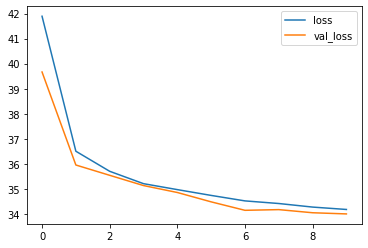

In [66]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_array = list(range(epochs))
plt.plot(epochs_array, loss, label="loss")
plt.plot(epochs_array, val_loss, label="val_loss")
plt.legend()

print("Plot:")

In [79]:
import json

def save_model(model, name):
    model_json = model.to_json()
    with open(name+".json", "w") as json_file:
        json.dump(model_json, json_file)

    model.save_weights(name+".h5")

#you might want to give your model an understandable filename

save_model(encoder,'saved/encoder_draw_10ep')
save_model(decoder,'saved/decoder_draw_10ep')

In [ ]:
# We can carry these files (*.h5, *.json) somewhere else ...
from keras.models import load_model
from keras.models import model_from_json
import json
def my_load_model(name):
    with open(name+'.json','r') as f:
        model_json = json.load(f)

    model = model_from_json(model_json)
    model.load_weights(name+'.h5')
    return model


decoder = my_load_model('decoder_draw_10ep')
encoder = my_load_model('encoder_draw_10ep')

(28, 28, 1)
1.0 0.0 0.5441127


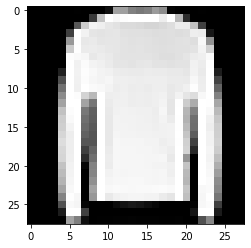

In [43]:
x1 = x_test[77] # number 73 picked for no reason at all
print(x1.shape)
print(np.max(x1), np.min(x1), np.mean(x1))

img = x1[:,:,0]

plt.figure(figsize=(4,4))
plt.imshow(img, cmap='gray', vmin=0.0, vmax=1.0)
plt.show()

In [52]:
z.shape

(1, 40)

(1, 40)
6.8676333 -6.105296 -0.2760364


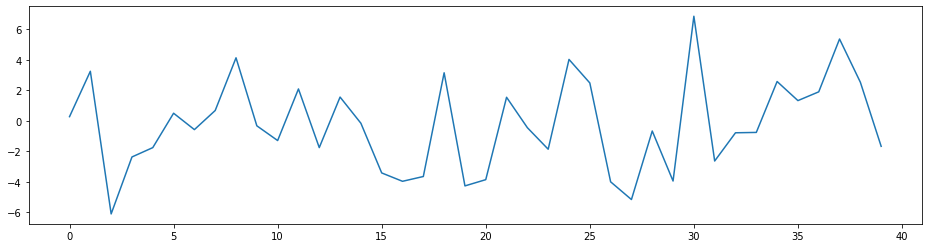

In [55]:
# Latent vector:

x1_arr = np.asarray([x1])
z, z_mean, z_log_var = encoder.predict(x1_arr)
print(z.shape)
print(np.max(z), np.min(z), np.mean(z))

plt.figure(figsize=(16,4))
plt.plot(z[0])
plt.show()

(1, 28, 28, 1)


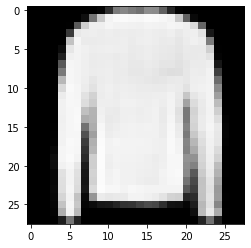

In [56]:
# Reconstructed image

y1 = decoder.predict(z)
print(y1.shape)
y1 = y1[0]

img = y1[:,:,0]

plt.figure(figsize=(4,4))
plt.imshow(img, cmap='gray', vmin=0.0, vmax=1.0)
plt.show()

In [59]:
def plot_tripple(image, vector, reconstruction):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.suptitle('Image > Representation > Reconstruction')
    ax1.imshow(image, cmap='gray', vmin=0.0, vmax=1.0)
    ax2.plot(vector)
    ax2.set_aspect(3.1)
    ax3.imshow(reconstruction, cmap='gray', vmin=0.0, vmax=1.0)

def plot_single(image):
    plt.figure(figsize=(1,1))
    plt.imshow(image, cmap='gray', vmin=0.0, vmax=1.0)
    plt.show()

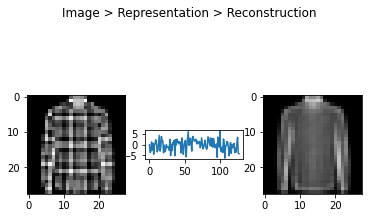

In [67]:
x1 = x_test[7] # Randomly pick 9th image from test set
z, z_mean, z_log_var = encoder.predict(np.asarray([x1])) 
y1 = decoder.predict(z)

plot_tripple(x1[:,:,0], z[0], y1[0,:,:,0])

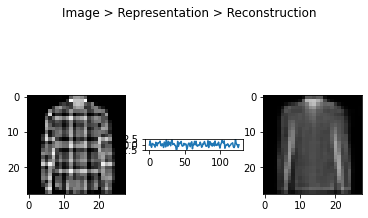

In [72]:
x1 = x_test[7] # Randomly pick 9th image from test set
z, z_mean, z_log_var = encoder.predict(np.asarray([x1])) 
y1 = decoder.predict(z)

plot_tripple(x1[:,:,0], z[0], y1[0,:,:,0])

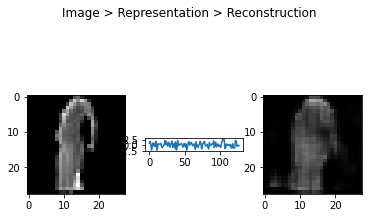

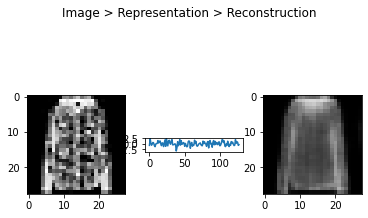

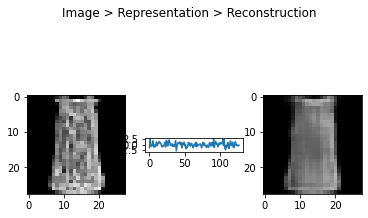

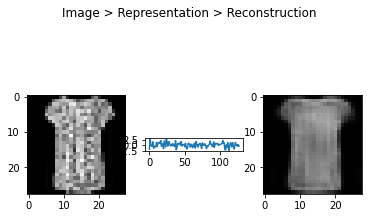

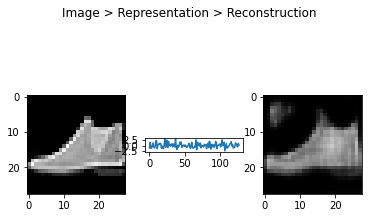

In [73]:
from random import randrange
for i in range(5):
    x1 = x_test[randrange(len(x_test))]
    z, z_mean, z_log_var = encoder.predict(np.asarray([x1]))
    y1 = decoder.predict(z)
    plot_tripple(x1[:,:,0], z[0], y1[0,:,:,0])

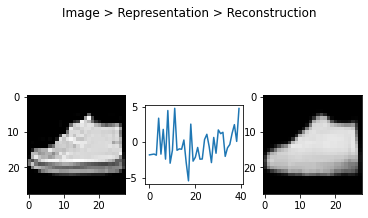

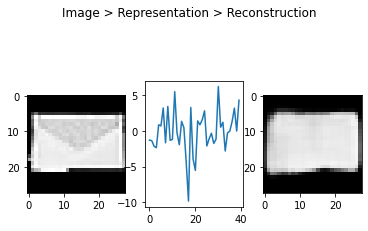

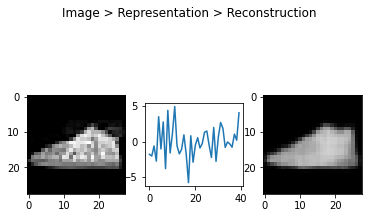

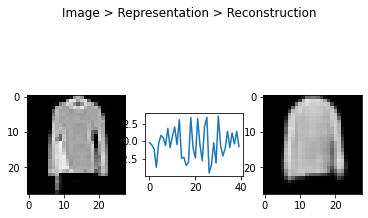

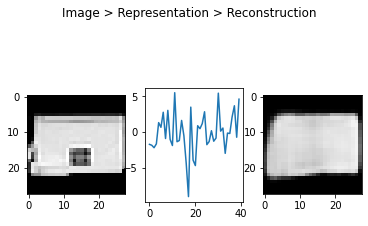

In [61]:
from random import randrange
for i in range(5):
    x1 = x_test[randrange(len(x_test))]
    z, z_mean, z_log_var = encoder.predict(np.asarray([x1]))
    y1 = decoder.predict(z)
    plot_tripple(x1[:,:,0], z[0], y1[0,:,:,0])

z_sample_a_encoded: (1, 32)
z_sample_b_encoded: (1, 32)


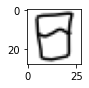

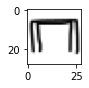

In [ ]:
sample_a = x_test[2] 
z_sample_a_encoded, _, _ = encoder.predict(np.asarray([sample_a]))

sample_b = x_test[3] 
z_sample_b_encoded, _, _ = encoder.predict(np.asarray([sample_b]))

print("z_sample_a_encoded:", z_sample_a_encoded.shape)
print("z_sample_b_encoded:", z_sample_b_encoded.shape)

#Let's show both original images 
plot_single(sample_a.reshape((28,28)))
plot_single(sample_b.reshape((28,28)))

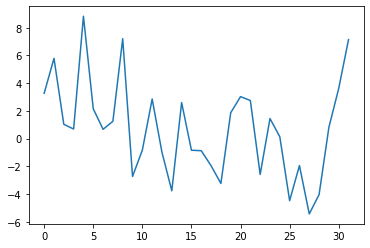

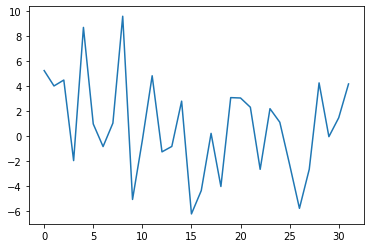

In [ ]:
# Show the latent vectors for each image
plt.plot(z_sample_a_encoded[0])
plt.show()
plt.plot(z_sample_b_encoded[0])
plt.show()

In [ ]:
# Define a function to linearly interpolate from one latent vector for another,
# specifically a*100% of the way there (i.e., if a=0.25, then we'll be 25% of the way from a to b)
def lerp(u,v,a):
    # linear interpolation between vectors u and v
    return a*u + (1-a)*v

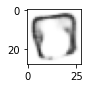

In [ ]:
a = 0.5  #show one image halfway between a and b
z_mix = lerp(z_sample_a_encoded, z_sample_b_encoded, a)
image = decoder.predict(z_mix) # shape comes as (1,28,28,1)
image = image.reshape((28,28))

plot_single(image)

0.0 :


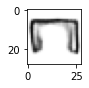

0.2 :


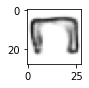

0.4 :


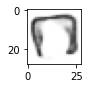

0.6 :


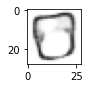

0.8 :


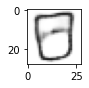

1.0 :


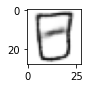

In [ ]:
# Now interpolate in a set number of steps
steps = 5
for i in range(steps + 1):
    # Goes from 0.0 to 1.0 in <steps> steps
    a_01 = float(i) / float(steps)
    z_mix = lerp(z_sample_a_encoded, z_sample_b_encoded, a_01)
    y = decoder.predict(z_mix)
    image = y.reshape((28,28))
    print(a_01,":")
    plot_single(image)

latent =  [[ 6.56511813  1.28076493 -3.79455155  2.99157182  5.03373999 -3.80211182
  -4.66549717  7.78371878 -6.07247675  9.65680186  8.37823332  3.48506669
   0.80641464 -0.69309302  0.27876906  8.43981539 -0.22973873 -5.43315044
  -9.81859751  0.82058575 -0.39954728 -2.91289506  4.28902209  2.27020466
  -7.03450401 -0.62659896  2.53531095  6.64719821  1.71398204 -0.20090036
  -4.78652875  3.55591628]]


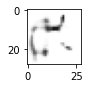

In [ ]:
# Random latent
latent = np.random.randn(1, 32) * 5
print("latent = ",latent)

image = decoder.predict(latent)
image = image.reshape((28,28))

plot_single(image)

latent =  [999.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.]


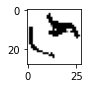

In [ ]:
# We can try to break it ...

latent = np.zeros(32)
latent[0] = 999.0 # oversaturated?
print("latent = ",latent)

image = decoder.predict(latent.reshape(1,32))
image = image.reshape((28,28))

plot_single(image)

In [ ]:
import shutil 
import cv2
import imageio, glob

#linear interpolation function 
def f(x):
  return x

def interpolate(size = 10):
  if os.path.exists("images"):
    shutil.rmtree("images")
    os.makedirs('images')
  else:
    os.makedirs('images')
    
  
  
  #get 3 random batches each of size 3 
  batches = []
  for _ in range(0, 3):
    i1 = np.random.randint(0, len(x_train))
    i2 = np.random.randint(0, len(x_train))
    batches.append([x_train[i1:i1+3], x_train[i2:i2+3]])
 
  i = 0   
  for x in list(np.linspace(0, 1, size)):
    frame = None
    j = 0 
    
    #interpolate each batch and concatenate them at the end to create 3x3 images
    for (x1, x2) in batches:
    
      
      v1,_,_ = encoder.predict(x1) 
      v2,_,_ = encoder.predict(x2)
        
      #use a linear interpolater
      v = (float(x))*v1 + (1.0 - float(x))*v2
      
      #get the output and reshape it 
      y = decoder.predict(v)
      img = np.reshape(y, (3 * 28, 28))
      img = img * 255
      
      #concatenate the batches 
      if frame is None:
        frame = img
      else:
        frame = np.concatenate([frame, img], axis = 1)
      j += 1
      
    #write the current frame to the disk 
    frame = cv2.resize(frame, (256, 256))  
    cv2.imwrite(f'images/image{i}.png', frame)
    i+=1

In [ ]:
!mkdir images
!ls images

mkdir: images: File exists
image0.png image2.png image4.png image6.png image8.png
image1.png image3.png image5.png image7.png image9.png


In [ ]:
interpolate(size = 10)

with imageio.get_writer('lsi.gif', mode='I', duration=0.35) as writer:
  filenames = glob.glob('images/image*.png')
  filenames = sorted(filenames)
  
  for i,filename in enumerate(filenames):
    image = imageio.imread(filename)
    writer.append_data(image)
    
# this is a hack to display the gif inside the notebook
os.system('cp lsi.gif lsi.gif.png')

0

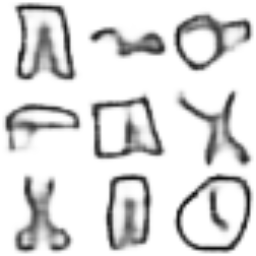

In [ ]:
from IPython import display 
display.Image(filename="lsi.gif.png")

In [ ]:
# https://github.com/zaidalyafeai/Notebooks/blob/master/AutoEncoders.ipynb

In [74]:
encoder

In [75]:
x_train.shape

(60000, 28, 28, 1)

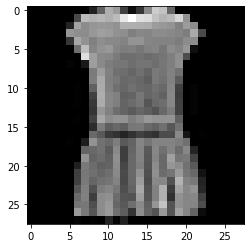

In [85]:
plt.imshow(x_train[3,:,:,0],cmap='gray')

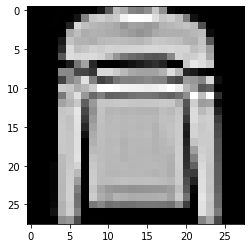

In [87]:
plt.imshow(x_train[5,:,:,0],cmap='gray')

In [106]:
z_1, _, _ = encoder.predict(np.expand_dims(x_train[3],axis=0)) #(28,28,1) -> (1,28,28,1)

In [107]:
z_2, _, _ = encoder.predict(np.expand_dims(x_train[5],axis=0)) #(28,28,1) -> (1,28,28,1)

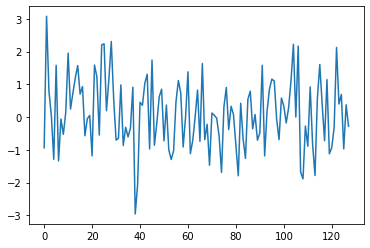

In [108]:
plt.plot(z_1[0])

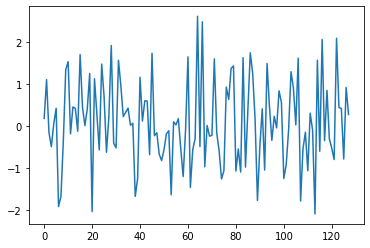

In [109]:
plt.plot(z_2[0])

In [125]:
from scipy.spatial import distance

In [126]:
distance.euclidean(z_1,z_2)

10.311128616333008

In [113]:
z_mid = (z_1 + z_2)/2

In [133]:
z_data, _, _ = encoder(x_train[:10000])

In [196]:
z_data.shape

TensorShape([10000, 128])

In [160]:


selection=[5843,5]

distances = np.zeros((z_data.shape[0],))

for i, z_this in enumerate(z_data):
  dist = distance.euclidean(z_mid, z_this)
  distances[i] = dist
  if i in sequence:
    distances[i] = 100
  

In [161]:
np.argmin(distances)

1721

In [145]:
a = ['a', 'b', 'c' , 'd']

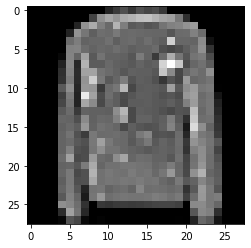

In [150]:
plt.imshow(x_train[5843,:,:,0],cmap='gray')

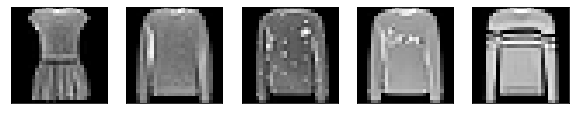

In [162]:
sequence = [3,8277,5843,1721,5]

# _Plot 25 images by matplotlib.pyplot

plt.figure(figsize=(10,6))
for i in range(len(sequence)):
    plt.subplot(1,len(sequence),i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[sequence[i]][:,:,0], cmap='gray')
plt.show()

In [182]:
sequence = np.array([1,2,3,4,5,6,7,8,9])

In [183]:
from math import ceil

In [206]:
selection = [3,5]

sequence = np.zeros((9,)).astype(int)
sequence[0] = selection[0]
sequence[-1] = selection[1]

In [207]:
sequence

array([3, 0, 0, 0, 0, 0, 0, 0, 5])

In [208]:
def find_sequence(sequence,z_data):
  lens = len(sequence)

  if lens==2:
    return sequence
  
  # calculate middle
  z_mid = (z_data[sequence[0]] + z_data[sequence[-1]])/2

  # find closest x_train
  distances = np.zeros((z_data.shape[0],))

  for i, z_this in enumerate(z_data):
    dist = distance.euclidean(z_mid, z_this)
    distances[i] = dist
    if i in sequence:
      distances[i] = 100

  # sequence middle index = argmin()
  sequence[int(lens/2)] = np.argmin(distances)

  first_half = find_sequence(sequence[:ceil(lens/2)],z_data)
  second_half = find_sequence(sequence[-ceil(lens/2):], z_data)

  merge = np.concatenate((first_half,second_half[1:]),axis=0)
  print(merge)

  return merge


In [209]:
test = find_sequence(sequence,z_data)

[   3 7585 2109]
[2109 8238 5843]
[   3 7585 2109 8238 5843]
[5843 7466 8220]
[8220 7025    5]
[5843 7466 8220 7025    5]
[   3 7585 2109 8238 5843 7466 8220 7025    5]


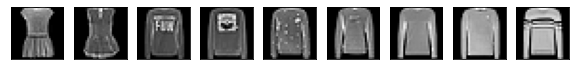

In [210]:
sequence = test

plt.figure(figsize=(10,6))
for i in range(len(sequence)):
    plt.subplot(1,len(sequence),i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[sequence[i]][:,:,0], cmap='gray')
plt.show()